In [ ]:
import numpy as np
import scvi 
import torch
import pandas as pd
import torch.distributions as dist
import scanpy as sc
from scCFM.models.base.vae import VAE, AE
from scCFM.models.base.geometric_vae import GeometricNBAE,GeometricNBVAE
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from scvi.distributions import NegativeBinomial
from tqdm import tqdm

import scipy as sp
import  matplotlib.pyplot as plt

from typing import Optional

import torch
from torch.distributions import kl_divergence

from stochman.manifold import Manifold
from stochman.curves import BasicCurve, CubicSpline

from scCFM.models.manifold.geodesic import sc_geodesic_minimizing_energy
from scCFM.models.utils import get_distribution
from scCFM.models.manifold.utils import nb_kl

## Geodesic distance

Exploit the manifold object from stochman

In [3]:
def compute_geodesic_dist(manifold, c):
    # Compute the curve and length
    alpha = torch.linspace(0, 1, 100)  # Space of times selected
    traj = c(alpha)  # Computation of the curve at the given times (spline)
    return manifold.curve_length(traj)  # Calculation of the length 

## Single-cell statistical manifold

In [4]:
class scStatisticalManifold(Manifold):
    def __init__(self, model, is_latent=True):
        # The VAE model 
        self.model = model 
        self.is_latent = is_latent  # Whether the manifold is a latent manifold
        
    def curve_energy(self, curve: torch.Tensor):
        """
        Given a curve of length L, measure the energy of given the KL divergence between subsequent points.
        """
        if len(curve.shape) == 2:
            curve = curve.unsqueeze(0)
        dt = (curve[:, :-1] - curve[:, 1:]).pow(2).sum(dim=-1).sqrt().squeeze(1)  # b
        kl = self._decode_and_kl(curve)
        return torch.sum(kl.view(kl.shape[0], -1), dim=1) * (2 * (dt ** -1))

    def curve_length(self, curve: torch.Tensor):
        """
        Given a curve of length L, measure the length of given the KL divergence between subsequent points.
        """
        if len(curve.shape) == 2:
            curve = curve.unsqueeze(0)
        kl = self._decode_and_kl(curve)
        return torch.sqrt(2 * torch.sum(kl.view(kl.shape[0], -1), dim=1))

    def connecting_geodesic(self, 
                            p0, 
                            p1, 
                            init_curve: Optional[BasicCurve] = None, 
                            max_iter=100, 
                            eval_grid=100, 
                            lr=1e-4, 
                            minimize_energy=False, 
                            return_losses=True):
        """
        Parameterize a spline as the shortest connecting curve in terms of length (or energy)
        """
        # Decouple curve and library size
        curve = CubicSpline(p0, p1)
        
        # Train the geodesic spline 
        losses = sc_geodesic_minimizing_energy(curve, 
                                                self, 
                                                max_iter=max_iter, 
                                                eval_grid=eval_grid,
                                                lr=lr, 
                                                minimize_energy=minimize_energy, 
                                                return_losses=return_losses)
        return curve, losses

    def metric(self, z, decoder_outputs):    
        """
        The metric is the pullback metric
        """
        # Compute the value of the Fisher matrix
        if self.model.likelihood == "nb":
            nb_fisher = self.model.theta.unsqueeze(0) / \
                (decoder_outputs["mu"] * (self.model.theta.unsqueeze(0) + decoder_outputs["mu"]))  # B x D
        else:
            raise NotImplementedError
        
        # Use the canonical basis vectors to select separate columns of the decoder (speed reasons)
        basis =  torch.eye(z.shape[1])
        basis = basis.unsqueeze(0).expand(z.shape[0], z.shape[1], z.shape[1])  # B x d x d
        
        # Compute the statistical manifold metric tensor 
        jac = []
        for i in range(z.shape[1]):
            _, jac_partial = torch.func.jvp(self.model.decode,
                                            (z,), 
                                            (basis[:, :, i],))  # B x D
            jac.append(jac_partial)

        jac = torch.stack(jac, dim=-1)  # B x D x d
        return torch.einsum("bij,bik->bjk", jac, jac * nb_fisher.unsqueeze(-1))
    
    def _decode_and_kl(self, curve):
        """
        Perform decoding and compute the KL (or other notion of metrics) between successive steps.
        """
        if not self.is_latent:
            decoder_outputs1 = {"mu": curve[:, :-1, :]}
            decoder_outputs2 =  {"mu": curve[:, 1:, :]}
            dist1 = get_distribution(decoder_outputs1, 
                                     self.model.theta, 
                                     likelihood = "nb")
            dist2 = get_distribution(decoder_outputs2, 
                                     self.model.theta, 
                                     likelihood = "nb")
            kl = nb_kl(dist1, dist2)  
        else:
            decoder_outputs1 = self.model.decode(curve[:, :-1, :])
            decoder_outputs2 = self.model.decode(curve[:, 1:, :])
    
            dist1 = get_distribution(self.model._preprocess_decoder_output(decoder_outputs1), 
                                     self.model.theta, 
                                     likelihood = self.model.likelihood)
            dist2 = get_distribution(self.model._preprocess_decoder_output(decoder_outputs2), 
                                     self.model.theta, 
                                     likelihood = self.model.likelihood)
            kl = nb_kl(dist1, dist2)  
        return kl

# Simulate dataset, same for all

In [5]:
# Set seed for reproducibility
torch.manual_seed(42)

# Parameters
num_genes = 10  # Number of genes
num_cells = 1000  # Number of cells
num_cell_types = 3  # Number of cell types

dist_means = [dist.Normal(torch.zeros(num_genes)+1, torch.ones(num_genes)),
              dist.Normal(torch.zeros(num_genes), torch.ones(num_genes)),
              dist.Normal(torch.zeros(num_genes)-1, torch.ones(num_genes))]

In [6]:
# Generate inverse dispersion parameters (theta)
# Assume inverse dispersions are sampled from a gamma distribution
inverse_dispersion = torch.abs(torch.distributions.Gamma(2.0, 1.0).sample((num_genes,)))

# Generate size factors for each cell
size_factors = torch.exp(torch.distributions.LogNormal(0, 0.1).sample((num_cells,)))

# Assign cells to cell types (assuming balanced classes)
cell_type_indices = torch.randint(0, num_cell_types, (num_cells,))

In [7]:
# Initialize the counts matrix
counts = torch.zeros((num_cells, num_genes))
means = torch.zeros((num_cells, num_genes))

# Simulate counts for each cell
for i in range(num_cells):
    cell_type = cell_type_indices[i]
    mean = dist_means[cell_type].sample()
    # mu = size_factors[i] * torch.exp(mean)
    mu = torch.exp(mean)
    theta = inverse_dispersion

    means[i, :] = mu
    counts[i, :] = NegativeBinomial(mu=mu, theta=theta).sample()

# Show the first few simulated counts
print("Simulated Counts Matrix (first 5 cells, all 10 genes):")
print(counts[:5, :])  # Show first 5 cells and all 10 genes

Simulated Counts Matrix (first 5 cells, all 10 genes):
tensor([[ 0.,  0.,  0.,  0., 95.,  0.,  0.,  0.,  6.,  5.],
        [ 0.,  1.,  0.,  0.,  1.,  2.,  7.,  2.,  0.,  0.],
        [ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  2.],
        [ 1.,  2.,  2.,  1.,  5.,  1.,  4.,  0.,  1.,  3.],
        [ 0.,  3.,  5.,  2.,  0.,  2.,  9.,  0.,  0., 28.]])


# Scanpy visualization

In [8]:
adata = sc.AnnData(X=counts.numpy().copy(), 
                  obs=pd.DataFrame({"cell_type": cell_type_indices.numpy()}))
adata.obs["cell_type"]=adata.obs["cell_type"].astype("category")

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


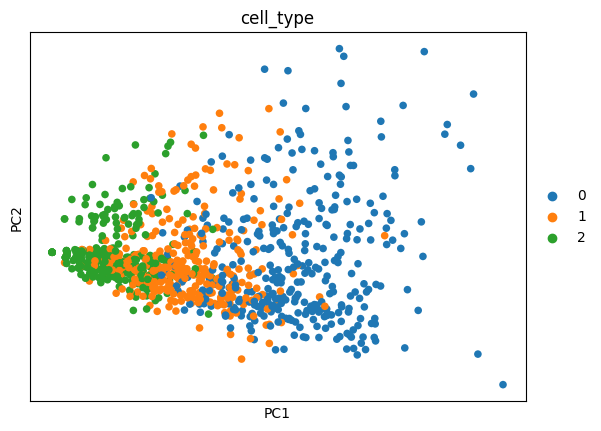

In [10]:
sc.pl.pca(adata, color="cell_type")

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


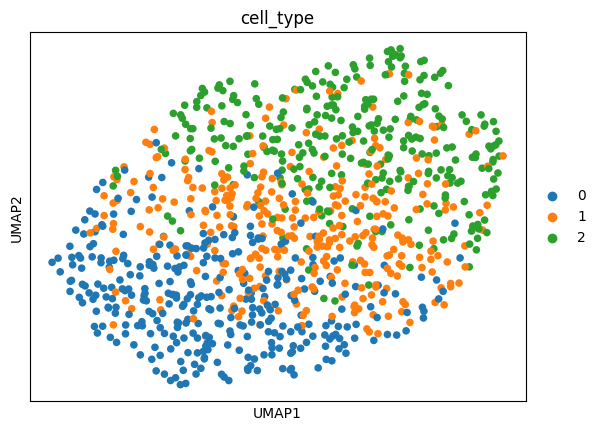

In [11]:
sc.pl.umap(adata, color="cell_type")

In [12]:
counts

tensor([[ 0.,  0.,  0.,  ...,  0.,  6.,  5.],
        [ 0.,  1.,  0.,  ...,  2.,  0.,  0.],
        [ 1.,  1.,  0.,  ...,  0.,  3.,  2.],
        ...,
        [ 0.,  3., 72.,  ...,  0.,  1.,  2.],
        [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  ...,  0., 15.,  1.]])

In [13]:
class SingleCellDataset(Dataset):
    def __init__(self, counts):
        self.counts = counts

    def __len__(self):
        return len(self.counts)

    def __getitem__(self, idx):
        return {"X": self.counts[idx]}

# Create an instance of the custom dataset
dataset = SingleCellDataset(counts)

# Create a DataLoader to iterate over the dataset
batch_size = 32  # You can choose an appropriate batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Fixed indivdual points to test for all

Test the geodesic between a fixed amount of couples between VAE and FlatVI.

In [14]:
np.random.seed(1)
couples = []
for _ in range(1000):
    i = np.random.choice(range(1000))
    j = np.random.choice(range(1000))
    couples.append((i,j))

## Compute results with replicates

In [15]:
results_metric_data_space = {
    "nll": [],
    "rep": [],
    "fl_weight": [],
    "eu_latent_space": [],
    "pullback_latent_space":[]
}
mse_params = {"fl_weight": [],
             "mse_mean": [],
             "mse_inv": [],
             "rep": []}

# VAE arguments stay the same
vae_kwargs = dict(in_dim=10,
                    hidden_dims=[5, 2],
                    batch_norm=False,
                    dropout=False,
                    dropout_p=False,
                    n_epochs_anneal_kl=500,
                    kl_warmup_fraction=2,
                    kl_weight=None, 
                    likelihood="nb", 
                    learning_rate=0.001, 
                    model_library_size=False)

fl_to_try = [10,7,5,3,1,0]
# fl_to_try = [10,0]

for fl in tqdm(fl_to_try):
    for rep in tqdm(range(3)):
        if fl == 0:
            model = VAE(**vae_kwargs) 
        else:
            model = GeometricNBVAE(l2=True,
                            interpolate_z=False,
                            eta_interp=0,
                            start_jac_after=0,
                            use_c=False,
                            compute_metrics_every=1,
                            vae_kwargs=vae_kwargs, 
                            detach_theta=False,
                            fl_weight=fl,
                            trainable_c=False,
                            anneal_fl_weight=False, 
                            max_fl_weight=False,
                            n_epochs_anneal_fl=None, 
                            fl_anneal_fraction=None)
    
        # Fit model 
        trainer = Trainer(max_epochs=100, 
                          enable_model_summary=False, 
                          enable_progress_bar=False)
        
        trainer.fit(model=model, 
                    train_dataloaders=dataloader, 
                    val_dataloaders=dataloader)
        
        results_metric_data_space["nll"] += [trainer.callback_metrics["val/lik"]]*1000
        results_metric_data_space["rep"] += [rep]*1000
        results_metric_data_space["fl_weight"] += [fl]*1000

        # Pred means
        pred_means = []
        with torch.no_grad():
            for i in counts:
                z = model.encode(i.unsqueeze(0))["z"]
                pred_means.append(torch.exp(model.decode(z)))
            pred_means = torch.cat(pred_means, dim=0)
            mse_mean = torch.mean((means - pred_means)**2)
            mse_inv = torch.mean((torch.exp(model.theta) - theta)**2)
        mse_params["fl_weight"].append(fl)
        mse_params["mse_mean"].append(mse_mean)
        mse_params["mse_inv"].append(mse_inv)
        mse_params["rep"].append(rep)

        # Initialize the manifolds 
        latent_manifold = scStatisticalManifold(model, is_latent=True)
        for idx in range(1000):
            i = couples[idx][0]
            j = couples[idx][1]
            # Get latent space
            with torch.no_grad():
                latent_i = model.encode(counts[i].unsqueeze(0))["z"]
                latent_j = model.encode(counts[j].unsqueeze(0))["z"]
            # Euclidean distance 
            results_metric_data_space["eu_latent_space"].append(torch.sum((latent_i - latent_j)**2).item())
            # Pullback distance 
            c = latent_manifold.connecting_geodesic(latent_i, latent_j, minimize_energy=False)[0]
            results_metric_data_space["pullback_latent_space"].append(compute_geodesic_dist(latent_manifold, c).item())
            
        del model
        del trainer
        del latent_manifold

  0%|          | 0/3 [00:00<?, ?it/s]/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/scCFM/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/scCFM/lib ...
  rank_zero_warn(
Y

# Print metrics

In [16]:
for i in results_metric_data_space:
    print(len(results_metric_data_space[i]))

18000
18000
18000
18000
18000


In [17]:
df = pd.DataFrame(results_metric_data_space)
df["nll_new"] = [i.item() for i in df["nll"]]

In [18]:
for fl in fl_to_try:
    df_fl = df.loc[df.fl_weight==fl]
    print(f"Distance data geodesic: {fl}", 
         np.nanmean((np.array(df_fl["pullback_latent_space"])-
                     np.array(df_fl["eu_latent_space"]))**2))

Distance data geodesic: 10 11.795788771229399
Distance data geodesic: 7 8.016559402152144
Distance data geodesic: 5 8.648937598321066
Distance data geodesic: 3 16.74588407927997
Distance data geodesic: 1 46.334577169181635
Distance data geodesic: 0 47.75487032076282


In [19]:
df["diff"] = (np.array(df["pullback_latent_space"])-
                     np.array(df["eu_latent_space"]))**2

In [20]:
for fl in fl_to_try:
    df_fl = df.loc[df.fl_weight==fl]
    print(f"Distance data geodesic: {fl}", 
         np.nanstd((np.array(df_fl["pullback_latent_space"])-
                     np.array(df_fl["eu_latent_space"]))**2))

Distance data geodesic: 10 26.355110320429205
Distance data geodesic: 7 19.619375851500948
Distance data geodesic: 5 25.098068664672383
Distance data geodesic: 3 38.65566723797122
Distance data geodesic: 1 102.03621773874676
Distance data geodesic: 0 101.079568606397


In [21]:
df = df.loc[:, ["diff","fl_weight","rep"]]

In [22]:
df.groupby(["fl_weight","rep"]).mean().groupby(["fl_weight"]).mean()

,diff
fl_weight,
0,47.756817
1,46.340551
3,16.745884
5,8.647072
7,8.016619
10,11.795789


In [23]:
df.groupby(["fl_weight","rep"]).mean().groupby(["fl_weight"]).std() / 3

,diff
fl_weight,
0,2.809705
1,6.452090
3,2.321362
5,1.689972
7,0.676194
10,1.035335


<!-- mse_params.keys() -->

## MSE params

In [24]:
mse_params_d = pd.DataFrame(mse_params)

In [25]:
mse_params_d["mse_mean"] = [i.item() for i in mse_params_d["mse_mean"]]

In [26]:
mse_params_d["mse_inv"] = [i.item() for i in mse_params_d["mse_inv"]]

In [27]:
mse_params_d.groupby("fl_weight").mean()

,mse_mean,mse_inv,rep
fl_weight,,,
0,15.521045,3.095800,1.0
1,16.346144,5.674503,1.0
3,16.356258,3.094841,1.0
5,14.752853,3.204940,1.0
7,15.476633,3.386602,1.0
10,15.410220,3.083079,1.0


In [28]:
mse_params_d.groupby(["fl_weight","rep"]).mean().groupby(["fl_weight"]).mean()

,mse_mean,mse_inv
fl_weight,,
0,15.521045,3.095800
1,16.346144,5.674503
3,16.356258,3.094841
5,14.752853,3.204940
7,15.476633,3.386602
10,15.410220,3.083079


In [29]:
mse_params_d.groupby(["fl_weight","rep"]).mean().groupby(["fl_weight"]).std()/3

,mse_mean,mse_inv
fl_weight,,
0,0.942972,0.186211
1,0.458422,0.881628
3,0.534342,0.308319
5,0.118357,0.198553
7,0.201369,0.088063
10,0.073452,0.129459
